#### <center>======================================================================================</center>
# <center>**Université Paris 1 Panthéon-Sorbonne**</center>
## <center>Projet d'Algorithmique et Python</center>
### <center>*Présenté par :* </center>
<center>Berthony Sully</center>
<center>Agui Tchabou</center>
<center>Landy Clément</center>
<center>Jerrold Nemba</center>

### <center>Au professeur : **Nicolas Bourgeois** </center>

<center>26 Janvier 2022</center>

#### <center>======================================================================================</center>



# Contents

1. [**Summary**](#sec1)
2. [**Data Processing**](#sec2)
    - [*Import tools and primary data*](#sec2.1)
    - [*Merging original data*](#sec2.2)
    - [*Missing values handling*](#sec2.3)
    - [*Sampling problem (Improper balance of the data)*](#sec2.4)
        + [Merging classes](#sec2.4.1)
        + [Features and target selection](#sec2.4.2)
        + [Using undersampling methods (imblearn)](#sec2.4.3)
3. [**Models classification**](#sec3)
4. [**Formulation 1 (4 classes problem)**](#sec4)
    - [*Random Forest (RF)*](#sec4.1)
    - [*Extreme gradient boosting (XGB)*](#sec4.2)
    - [*K-Nearest Neihgbors (KNN)*](#sec4.3)
    - [*Linear Discriminant Analysis (LDA)*](#sec4.4)
    - [*Conclusion*](#sec4.5)
5. [**Formulation 2 (3 classes problem)**](#sec5)
    - [*Random Forest (RF)*](#sec5.1)
    - [*Extreme gradient boosting (XGB)*](#sec5.2)
    - [*K-Nearest Neihgbors (KNN)*](#sec5.3)
    - [*Linear Discriminant Analysis (LDA)*](#sec5.4)
    - [*Conclusion*](#sec5.5)
6. [**Formulation 3 (binary problem)**](#sec6)
    - [*Random Forest (RF)*](#sec6.1)
    - [*Extreme gradient boosting (XGB)*](#sec6.2)
    - [*K-Nearest Neihgbors (KNN)*](#sec6.3)
    - [*Linear Discriminant Analysis (LDA)*](#sec6.4)
    - [*Conclusion*](#sec6.5)
7. [**Findings**](#sec7)

# 1. **Summary** <a id="sec1"></a>

The problem we are trying to approch here has been subject to some study by Ilyes Talbi, the author of the article [XGBoost vs Random Forest : prédire la gravité d’un accident de la route](https://larevueia.fr/xgboost-vs-random-forest-predire-la-gravite-dun-accident-de-la-route/) published in September 6, 2021 in the IA review. The author proposed as main problem to test and find the better algorithm between `Random Forest` and `XGBoost` in order to predict the gravity of the people who had a road accident in France. The data used in this study can be downloaded on the [Open Data Gouv](http://data.gouv.fr/) website.

The author found out that the `XGBoost` algorithm predicted better the labels than the Random Forest and their respective accuracy were given by `Random Forest : 60.35%` and `XGBoost : 65.9%`. The author also provided some opportunities for improvement like the tuning of the hyperparameters and the handling of the imbalanced proportions of the data. So this is the situation we want to address in this Notebook.

To provide a larger solution, we try to present some differents approaches to solve the problem. To do so, we proceeded like this : 
- We try to reformulate the problem three ways :
    * Firstly, we have the same problem as the author (4 classes).
    * Secondly, we merge the people who need medical attention (classes 3 and 4) and now we are dealing with a 3 classes problem.
    * Finaly, we let all the people who are killed in one class (class 2) and merge all the others classes and considered them as survivors (class 1).
- We introduce the `k-Nearest Neighbors` and the `Linear Discriminant Analysis (LDA)` algorithms to provide other grounds of comparison.
- We tuned the hyperparameters except for the `XGBoost` algorithm due to the numbers of parameters to specify and we leave the base `LDA` algorithm. The author also had the same problem for `XGBoost`.
- We used the `under sampling` method to handle the improper balanced data. However, a problem with this method is that we could lose some valuable informations in the prediction process that would potentially be helpful to the algorithm to predict the labels. And it was convenient for us also because of the computational problem that we would have in order to deal with at least 50000 observations by classes.
- Given that we also had to implement different methods, we ensured that the overwhelming part of our proposed solution is function based. So we defined the `cleansing()`, `merge_classes()`, `model_accuracy()`, `underSamp()`, `splitting()`, `tuning()` and `score_summary()` functions to automate some of our results.

At the end of our experience, we arrive as the same conclusion as the author of the article :
> The `XBGoost algorithm` performs better in the majority of the formulations, however the three ways we provided for handling the problem an offer some new perspectives and better understanding.

The only times were it's not the case is when we found out that the Random Forest algorithm has a better accuracy on the train set but the overfitting in the data undermined the confidence in the predictions. We found out also that the `LDA` algorithm can perform a quite good fit to the problem.

Now as improvement opportunities, it would be very interesting to tune the hyperparameters of the `XBGoost algorithm` in order to see exactly the limits of it. Our best results with it was in the binary problem were we had `79.3%` of accuracy.

# 2. **Data processing** <a id = "sec2"></a>

## *Import tools and primary data* <a id = "sec2.1"></a>

In [1]:

import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pprint import pprint
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


In [2]:
# Clone the githob repo to access the data
!git clone https://github.com/htsull/Algo_Python_Class_Project.git

Cloning into 'Algo_Python_Class_Project'...


In [3]:

df1 = pd.read_csv("Algo_Python_Class_Project/data/usagers.csv")
df2 = pd.read_csv("Algo_Python_Class_Project/data/vehicules.csv")
df3 = pd.read_csv("Algo_Python_Class_Project/data/caract.csv")
df4 = pd.read_csv("Algo_Python_Class_Project/data/lieux.csv")
print('Done')

Done


## *Merge original data* <a id = "sec2.2"></a>

In [4]:
data1 = df1.merge(df2,on=['Num_Acc','num_veh', 'id_vehicule'])
data2 = df3.merge(df4,on = 'Num_Acc')
data = data1.merge(data2,on='Num_Acc')

## *Missing values handling* <a id = "sec2.3"></a>

In [5]:
def cleansing(data_to_clean):
      print("=====================================================================")
      print("Dimension of the data : {}".format(data_to_clean.shape))
      print("=====================================================================")
      print(repr("Columns with more than 10% of missing values  :"))
      # count nan values
      nan_values = data_to_clean.isna().sum()
      # percentage of nan values ay column
      nan_values = nan_values.sort_values(ascending=False) *100 / data_to_clean.shape[0]
      # columns with nan values greater than 10%
      nan_values = nan_values.loc[nan_values > 10]
      print(nan_values)
      # Drop nan_values criteria columns
      data = data_to_clean.drop(nan_values.to_dict().keys(), axis=1)
      # Drop other column not concerned or not making sens in the process
      data = data.drop(['lat','secu1', 'secu2', 'secu3'], axis=1)
      print("=====================================================================")
  
      print("Processing the hrmn variable...")
      data.hrmn = data.hrmn.str.split(':').str[0]
      print("=====================================================================")
      
      print('Dimension of the data after dropping the variables with NaN more than 10% : {}'.format(data.shape))
      print("=====================================================================")
  
      print("Variables conversion in Category type...")
      cat = ['lum', 'agg', 'int', 'atm', 'col',
        'catr', 'circ', 'vosp', 'prof', 
       'plan', 'surf', 'infra', 'situ', 'senc',
       'catv', 'obs', 'obsm', 'choc', 'manv', 
       'catu', 'sexe', 'trajet', 'actp']

      data[cat] = data[cat].astype('category')
  
      drop = ['an_nais', 'motor', 'jour', 'mois', 'dep', 
        'com', 'adr', 'voie', 'nbv', 'pr', 'pr1',
        'Num_Acc', 'id_vehicule', 'num_veh']

      data = data.drop(drop, axis=1)
  
      print("=====================================================================")
      print("Variation of the variables...")
      print(data.var().sort_values().head())
  
      print("=====================================================================")
      data = data.drop('an', axis=1)
      print("Dimension of the data after dropping 'an' variable (No valuable informations) : {}".format(data.shape))
  
      print("=====================================================================")
      data = data.dropna(axis=0, how='any')
      print("Dimension of the data after dropping all rows with NaN: {}".format(data.shape))
  
      print("=====================================================================")

      print("**************************Cleansing done*****************************")
      print("=====================================================================")
      return data


In [6]:
data = cleansing(data)

Dimension of the data : (132977, 54)
'Columns with more than 10% of missing values  :'
long       100.000000
lartpc      99.648811
larrout     99.375080
occutc      98.587726
v2          92.673921
v1          18.567121
dtype: float64
Processing the hrmn variable...
Dimension of the data after dropping the variables with NaN more than 10% : (132977, 44)
Variables conversion in Category type...
Variation of the variables...
an       0.000000
etatp    0.420301
locp     1.556945
grav     1.881877
place    7.266928
dtype: float64
Dimension of the data after dropping 'an' variable (No valuable informations) : (132977, 29)
Dimension of the data after dropping all rows with NaN: (132883, 29)
**************************Cleansing done*****************************


## *Sampling problem handling (Improper balance of the data)* <a id = "sec2.4"></a>

In [7]:
def merge_classes(clean_data, classes = 4):
    """Merge classes of the 'grav' variable to simplify the problem.

    Args:
        clean_data (dataframe): datarame of data already cleaned by the function cleansing()
        classes (int, optional): numbers of classes to convert the 'grav' variable. Defaults to 4.
                                4 : labels (1 = 'Indemme', 2 = 'Tué', 3 = 'Blessé hospitalisé', 4 = 'Blessé léger')
                                3 : labels (1 = 'Indemme', 2 = 'Tué', 3 = 'Blessé') --> Blessé = Need medical attention
                                2 : labels (1 = 'Survivants', 2 = 'Tué')

    Returns:
        dataframe : dataframe with the 'grav' variable with the number of classes specified.
    """
    # df = clean_data.copy()
    if classes == 4 :
        df_c4 = clean_data.copy()
        print('Distibution between the {} classes : '.format(classes))
        print("labels (1 = 'Indemme', 2 = 'Tué', 3 = 'Blessé hospitalisé', 4 = 'Blessé léger')")
        print(df_c4.grav.value_counts())
        print("=========================================================")
        return df_c4
    elif classes == 3 :
        df_c3 = clean_data.copy()
        print('Distibution between the {} classes : '.format(classes))
        print("labels (1 = 'Indemme', 2 = 'Tué', 3 = 'Blessé') --> Blessé = Need medical attention")
        df_c3.grav.replace(4, 3, inplace=True)
        print(df_c3.grav.value_counts())
        print("=========================================================")
        return df_c3
    elif classes == 2 :
        df_c2 = clean_data.copy()
        print('Distibution between the {} classes : '.format(classes))
        print("labels (1 = 'Survivant', 2 = 'Tué')")
        df_c2.grav.replace(4, 1, inplace=True)
        df_c2.grav.replace(3, 1, inplace=True)
        print(df_c2.grav.value_counts())
        print("=========================================================")
        return df_c2
    else : 
        print("Insert a valid option")
        print("=========================================================")

### Merging classes <a id = "sec2.4.1"></a>

In [8]:
data4 = merge_classes(data, classes = 4)
data3 = merge_classes(data, classes = 3)
data2 = merge_classes(data, classes = 2)

Distibution between the 4 classes : 
labels (1 = 'Indemme', 2 = 'Tué', 3 = 'Blessé hospitalisé', 4 = 'Blessé léger')
1    55276
4    53256
3    20854
2     3497
Name: grav, dtype: int64
Distibution between the 3 classes : 
labels (1 = 'Indemme', 2 = 'Tué', 3 = 'Blessé') --> Blessé = Need medical attention
3    74110
1    55276
2     3497
Name: grav, dtype: int64
Distibution between the 2 classes : 
labels (1 = 'Survivant', 2 = 'Tué')
1    129386
2      3497
Name: grav, dtype: int64


### Features and target selection for classes merged <a id = "sec2.4.2"></a>

In [9]:
y4 = data4.grav
X4 = data4.drop(columns='grav')
y3 = data3.grav
X3 = data3.drop(columns='grav')
y2 = data2.grav
X2 = data2.drop(columns='grav')

### Using undersampling methods (imblearn) <a id = "sec2.4.3"></a>

In [10]:
# Install imblearn
# !pip install imblearn #Uncomment this line to install imblearn

In [11]:
def underSamp(X, y):
    rus = RandomUnderSampler(random_state=42, replacement=True)
    X_rus, y_rus = rus.fit_resample(X, y)
    print('Original dataset shape : ', Counter(y))
    print('Resample dataset shape : ', Counter(y_rus))
    return X_rus, y_rus

# 3. **Models Specification** <a id = "sec3"></a>

In [12]:

def model_accuracy(model):
    """Perform the fitting, print out the accuracy, classification report and confusion matrix with the given model

    Args:
        model(string) : model to perform. 'rf' : random forest, 'xgb' : XGBoost, 'knn' : K-Nearest Neighbors.

    Returns:
        classifier: model fit to the train set.
    """
    if model == 'rf':
        print("Random forest model")
        # fitting 
        model_rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
        # Predictions (test)
        predictions_test = model_rf.predict(X_test)
        model_rf_score = model_rf.score(X_test, y_test)
        print('Base model accuracy  : {:04.3f}'.format(model_rf_score))
        print("=========================================================================")
        print("Classification report : ")
        print(classification_report(y_test, predictions_test, digits=3, zero_division = 1)),
        disp = plot_confusion_matrix(model_rf, X_test, y_test, cmap='Reds', values_format='d',
                                    #  display_labels=labels_disp,
                                    xticks_rotation= 'vertical')
        print("=========================================================================")
        print("Confusion matrix : ")
        return model_rf
    
    elif model == 'xgb':
        print("Extreme gradient boosting model")
        # fitting 
        model_xgb = GradientBoostingClassifier().fit(X_train, y_train)
        print("=========================================================================")
        model_xgb_score = model_xgb.score(X_test, y_test)
        print("Fitting to the train set : {:04.2f}".format(model_xgb_score))
        # Predictions (test)
        print("=========================================================================")
        predictions_test = model_xgb.predict(X_test)
        print('Base model accuracy  : {:04.3f}'.format(model_xgb.score(X_test, y_test)))
        print("=========================================================================")
        print("Classification report : ")
        print(classification_report(y_test, predictions_test, digits=3, zero_division = 1)),
        disp = plot_confusion_matrix(model_xgb, X_test, y_test, cmap='Reds', values_format='d',
                                    #  display_labels=labels_disp,
                                    xticks_rotation= 'vertical')
        print("=========================================================================")
        print("Confusion matrix : ")
        return model_xgb
    
    elif model == 'knn':
        print("K-Nearest Neighbors model")
        # fitting 
        model_knn = KNeighborsClassifier().fit(X_train, y_train)
        predictions_test = model_knn.predict(X_test)
        model_knn_score = model_knn.score(X_test, y_test)
        print('Base model accuracy  : {:04.3f}'.format(model_knn_score))
        print("=========================================================================")
        print("Classification report : ")
        print(classification_report(y_test, predictions_test, digits=3, zero_division = 1)),
        disp = plot_confusion_matrix(model_knn, X_test, y_test, cmap='Reds', values_format='d',
                                    #  display_labels=labels_disp,
                                    xticks_rotation= 'vertical')
        print("=========================================================================")
        print("Confusion matrix : ")
        return model_knn
    
    elif model == 'lda':
        print("Linear Discriminant Ananlysis model (LDA)")
        # fitting 
        model_lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
        predictions_test = model_lda.predict(X_test)
        model_lda_score = model_lda.score(X_test, y_test)
        print('Base model accuracy  : {:04.3f}'.format(model_lda_score))
        print("=========================================================================")
        print("Classification report : ")
        print(classification_report(y_test, predictions_test, digits=3, zero_division = 1)),
        disp = plot_confusion_matrix(model_lda, X_test, y_test, cmap='Reds', values_format='d',
                                    #  display_labels=labels_disp,
                                    xticks_rotation= 'vertical');
        print("=========================================================================")
        print("Confusion matrix : ")
        return model_lda
    
    else :
        print("Enter a valid choice.")

# 4. **Formulation 1 (4 classes problem)** <a id = "sec4"></a>

In [13]:
# Undersampling 
X, y = underSamp(X4, y4)

Original dataset shape :  Counter({1: 55276, 4: 53256, 3: 20854, 2: 3497})
Resample dataset shape :  Counter({1: 3497, 2: 3497, 3: 3497, 4: 3497})


In [14]:

def splitting(X, y):
    """Use the train_test slit method from sklearn to separate the data

    Args:
        X : Features selected
        y : Target 

    Returns:
        splitting : list, length=2 * len(arrays)
                    List containing train-test split of inputs.
    """
    # hot encoding of the features
    X = pd.get_dummies(X.astype(str))
    # Normalizing the data
    X = normalize(X.values)
    # Splitting the data for training and test purpose
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size= .3)
    return X_train, X_test, y_train, y_test

In [15]:
# Data separation in train and test sets
X_train, X_test, y_train, y_test = splitting(X, y)

## *Random Forest* <a id = "sec4.1"></a>

Random forest model
Base model accuracy  : 0.566
Classification report : 
              precision    recall  f1-score   support

           1      0.670     0.748     0.707      1051
           2      0.559     0.598     0.578      1042
           3      0.485     0.429     0.455      1069
           4      0.528     0.490     0.508      1035

    accuracy                          0.566      4197
   macro avg      0.560     0.566     0.562      4197
weighted avg      0.560     0.566     0.562      4197

Confusion matrix : 


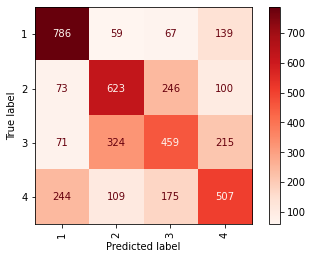

In [16]:
# Performing random forest model
model_rf = model_accuracy('rf')

### Hyperparameters tuning

In [17]:
# Define the grid of parameters
param_grid = {
    'n_estimators': [100, 200,400, 500]
}
# Instantiate the grid search model
grid = GridSearchCV(estimator = model_rf, param_grid = param_grid, cv = 5, n_jobs=-1)
# Fit the grid search to the data
best_rf_grid = grid.fit(X_train, y_train)

In [18]:
def tuning(model):
    """Perform tuning of the models parameters

    Args:
        model: perfomed models by the model_accuracy() function
    """
    if model == 'rf':
        
        print('Ramdom Forest model best parameters :', best_rf_grid.best_params_)
        best_rf_model = best_rf_grid.best_estimator_
        print("==============================================================================")
        print("Random forest final model :", best_rf_model)
        print("==============================================================================")
        print('Fitting to the train set : {:04.2f}'.format(best_rf_model.score(X_train, y_train)))
        print("==============================================================================")
        score_best_rf = best_rf_model.score(X_test, y_test)
        print('Final model Accuracy : {:04.3f}'.format(score_best_rf))
        print("==============================================================================")
        score_base_rf = model_rf.score(X_test, y_test)
        print("Base model accuracy : {:04.3f}".format(score_base_rf))
        print("==============================================================================")
        print("Classification report : ")
        best_rf_pred = best_rf_model.predict(X_test)
        print(classification_report(y_test, best_rf_pred, 
                                    digits=3, zero_division = 1))
        print("==============================================================================")
        print("Confusion matrix : ")
        disp = plot_confusion_matrix(best_rf_model, X_test, y_test, cmap='Reds', values_format='d',
                                    #  display_labels=labels_disp,
                                    xticks_rotation='vertical')
        return best_rf_model
    
    elif model == 'knn':
        
        print('KNN best parameters :', best_knn_grid.best_params_)
        best_knn_model = best_knn_grid.best_estimator_
        print("==============================================================================")
        print("KNN final model :", best_knn_model)
        print("==============================================================================")
        print('Fitting to the train set : {:04.2f}'.format(best_knn_model.score(X_train, y_train)))
        print("==============================================================================")
        score_best_knn = best_knn_model.score(X_test, y_test)
        print('Final model Accuracy : {:04.3f}'.format(score_best_knn))
        print("==============================================================================")
        score_base_knn = model_knn.score(X_test, y_test)
        print("Base model accuracy : {:04.3f}".format(score_base_knn))
        print("==============================================================================")
        print("Classification report : ")
        best_knn_pred = best_knn_model.predict(X_test)
        print(classification_report(y_test, best_knn_pred, 
                                    digits=3, zero_division = 1))
        print("==============================================================================")
        print("Confusion matrix : ")
        disp = plot_confusion_matrix(best_knn_model, X_test, y_test, cmap='Reds', values_format='d',
                                    #  display_labels=labels_disp,
                                    xticks_rotation='vertical')
        return best_knn_model
    else :
        print("'Enter a valid option...")

Ramdom Forest model best parameters : {'n_estimators': 400}
Random forest final model : RandomForestClassifier(n_estimators=400, random_state=42)
Fitting to the train set : 1.00
Final model Accuracy : 0.571
Base model accuracy : 0.566
Classification report : 
              precision    recall  f1-score   support

           1      0.669     0.741     0.703      1051
           2      0.571     0.606     0.588      1042
           3      0.505     0.433     0.466      1069
           4      0.520     0.507     0.514      1035

    accuracy                          0.571      4197
   macro avg      0.566     0.572     0.568      4197
weighted avg      0.566     0.571     0.567      4197

Confusion matrix : 


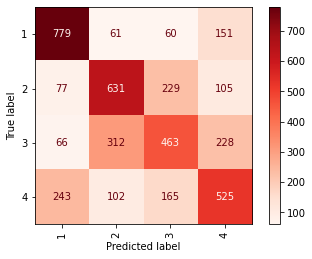

In [19]:
best_rf_model = tuning('rf')

## *Extreme Gradient boosting model (XGB)* <a id = "sec4.2"></a>

Extreme gradient boosting model
Fitting to the train set : 0.54
Base model accuracy  : 0.539
Classification report : 
              precision    recall  f1-score   support

           1      0.651     0.745     0.695      1051
           2      0.538     0.583     0.560      1042
           3      0.435     0.360     0.394      1069
           4      0.498     0.471     0.484      1035

    accuracy                          0.539      4197
   macro avg      0.530     0.540     0.533      4197
weighted avg      0.530     0.539     0.533      4197

Confusion matrix : 


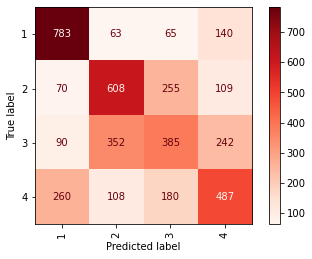

In [20]:
#  Perform XGB model
best_xgb_model = model_accuracy('xgb')

## *k-Nearest Neighbors* <a id = "sec4.3"></a>

K-Nearest Neighbors model
Base model accuracy  : 0.480
Classification report : 
              precision    recall  f1-score   support

           1      0.530     0.666     0.590      1051
           2      0.488     0.587     0.533      1042
           3      0.392     0.349     0.369      1069
           4      0.489     0.317     0.385      1035

    accuracy                          0.480      4197
   macro avg      0.475     0.480     0.469      4197
weighted avg      0.474     0.480     0.469      4197

Confusion matrix : 


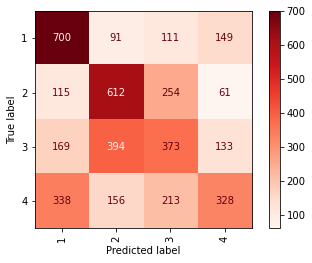

In [21]:
# Perform KNN
model_knn = model_accuracy('knn')

### Hyperparameters tuning for KNN

In [22]:
# Define the grid of parameters
param_grid = {
    'n_neighbors': [5, 7, 10, 15]
}
# Instantiate the grid search model
grid = GridSearchCV(estimator = model_knn, param_grid = param_grid, cv = 5, n_jobs=-1)
# Fit the grid search to the data
best_knn_grid = grid.fit(X_train, y_train)

KNN best parameters : {'n_neighbors': 15}
KNN final model : KNeighborsClassifier(n_neighbors=15)
Fitting to the train set : 0.58
Final model Accuracy : 0.488
Base model accuracy : 0.480
Classification report : 
              precision    recall  f1-score   support

           1      0.558     0.692     0.618      1051
           2      0.496     0.591     0.539      1042
           3      0.392     0.352     0.371      1069
           4      0.473     0.318     0.380      1035

    accuracy                          0.488      4197
   macro avg      0.480     0.488     0.477      4197
weighted avg      0.480     0.488     0.477      4197

Confusion matrix : 


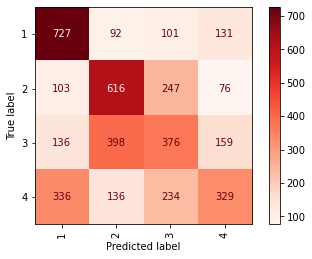

In [23]:
best_knn_model = tuning('knn')

## *Linear Discriminant Analysis (LDA)* <a id = "sec4.4"></a>

Linear Discriminant Ananlysis model (LDA)
Base model accuracy  : 0.531
Classification report : 
              precision    recall  f1-score   support

           1      0.674     0.716     0.694      1051
           2      0.536     0.550     0.543      1042
           3      0.420     0.410     0.415      1069
           4      0.481     0.449     0.465      1035

    accuracy                          0.531      4197
   macro avg      0.528     0.531     0.529      4197
weighted avg      0.527     0.531     0.529      4197

Confusion matrix : 


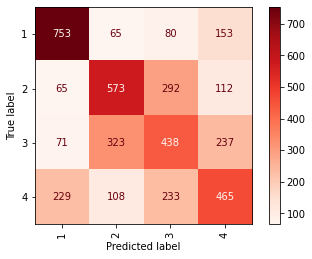

In [24]:
best_lda_model = model_accuracy('lda')

## *Conclusion* <a id = "sec4.5"></a>

### Score summary function

In [25]:
def score_summary():
    
    models = [] # append all models or predictive models 
    score_results = [] # cross validation result

    models.append(best_rf_model)
    models.append(best_knn_model)
    models.append(best_xgb_model)
    models.append(best_lda_model)

    for model in models :
        score_results.append(model.score(X_test, y_test)*100)
            
    cv_frame = pd.DataFrame(
        {
            "Algorithms":[
                        "RandomForest",
                        "KNeighboors",
                        "GradientBoosting",                      
                        "LinearDiscriminantAnalysis"
                        ],
            "CrossValMeans":score_results
        })

    cv_plot = sns.barplot(x="CrossValMeans",y="Algorithms", data = cv_frame,
                    palette="Paired", orient = "h");

    for p in cv_plot.patches:
        _x = p.get_x() + p.get_width() - 8
        _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
        value = '{:.2f}%'.format(p.get_width())
        cv_plot.text(_x, _y, value, ha="left")

    cv_plot.set_xlabel("Accuracy")
    cv_plot = cv_plot.set_title("Algorithms Scores Graph");


### Summary

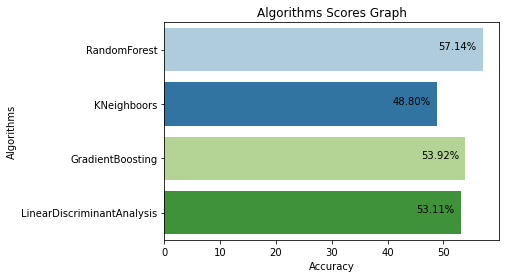

In [26]:
score_summary_4 = score_summary()

We found that the accuracy of the models after the tuning of the hyperparameters are : `Random Forest : 57.1%`, `XGB : 53.8%`, `LDA : 53.1` and `kNN : 48.8%`. The Random Forest model clearly did a better job than the other models at predicting the 4 classes problem. However, the overfitting of the data in the Random Forest model can push us tho use the `XGB classifier` to approach the problem and the differences in the accuracy metric is not that large.

# 5. **Formulation 2 (3 classes problem)** <a id = "sec5"></a>

In [27]:
# Undersampling 
X, y = underSamp(X3, y3)

Original dataset shape :  Counter({3: 74110, 1: 55276, 2: 3497})
Resample dataset shape :  Counter({1: 3497, 2: 3497, 3: 3497})


In [28]:
# Data separation in train and test sets
X_train, X_test, y_train, y_test = splitting(X, y)

## *Random Forest* <a id = "sec5.1"></a>

Random forest model
Base model accuracy  : 0.668
Classification report : 
              precision    recall  f1-score   support

           1      0.724     0.777     0.750      1063
           2      0.680     0.722     0.700      1054
           3      0.581     0.500     0.538      1031

    accuracy                          0.668      3148
   macro avg      0.662     0.667     0.663      3148
weighted avg      0.662     0.668     0.664      3148

Confusion matrix : 


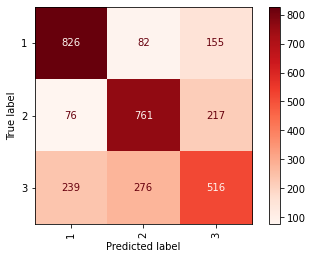

In [29]:
# Performing random forest model
model_rf = model_accuracy('rf')

### Hyperparameters tuning

In [30]:
# Define the grid of parameters
param_grid = {
    'n_estimators': [100, 200,400, 500]
}
# Instantiate the grid search model
grid = GridSearchCV(estimator = model_rf, param_grid = param_grid, cv = 5, n_jobs=-1)
# Fit the grid search to the data
best_rf_grid = grid.fit(X_train, y_train)

Ramdom Forest model best parameters : {'n_estimators': 500}
Random forest final model : RandomForestClassifier(n_estimators=500, random_state=42)
Fitting to the train set : 1.00
Final model Accuracy : 0.674
Base model accuracy : 0.668
Classification report : 
              precision    recall  f1-score   support

           1      0.737     0.784     0.760      1063
           2      0.684     0.724     0.703      1054
           3      0.583     0.510     0.544      1031

    accuracy                          0.674      3148
   macro avg      0.668     0.673     0.669      3148
weighted avg      0.669     0.674     0.670      3148

Confusion matrix : 


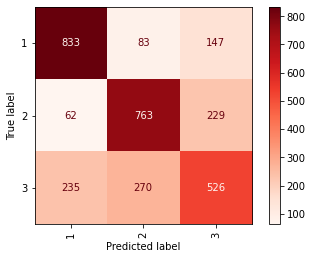

In [31]:
# Perform a tuning of the model specified
best_rf_model = tuning('rf')

## *Extreme Gradient boosting model (XGB)* <a id = "sec5.2"></a>

Extreme gradient boosting model
Fitting to the train set : 0.67
Base model accuracy  : 0.668
Classification report : 
              precision    recall  f1-score   support

           1      0.714     0.807     0.758      1063
           2      0.676     0.702     0.689      1054
           3      0.593     0.491     0.537      1031

    accuracy                          0.668      3148
   macro avg      0.661     0.667     0.661      3148
weighted avg      0.662     0.668     0.663      3148

Confusion matrix : 


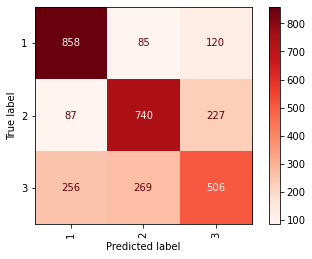

In [32]:
#  Perform XGB model
best_xgb_model = model_accuracy('xgb')

## *k-Nearest Neighbors (kNN)* <a id = "sec5.3"></a>

K-Nearest Neighbors model
Base model accuracy  : 0.590
Classification report : 
              precision    recall  f1-score   support

           1      0.603     0.736     0.663      1063
           2      0.653     0.657     0.655      1054
           3      0.485     0.372     0.421      1031

    accuracy                          0.590      3148
   macro avg      0.580     0.588     0.580      3148
weighted avg      0.581     0.590     0.581      3148

Confusion matrix : 


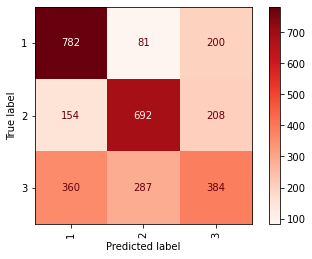

In [33]:
# Perform KNN
model_knn = model_accuracy('knn')

### Hyperparameters tuning for KNN

In [34]:
# Define the grid of parameters
param_grid = {
    'n_neighbors': [5, 7, 10, 15]
}
# Instantiate the grid search model
grid = GridSearchCV(estimator = model_knn, param_grid = param_grid, cv = 5, n_jobs=-1)
# Fit the grid search to the data
best_knn_grid = grid.fit(X_train, y_train)

KNN best parameters : {'n_neighbors': 15}
KNN final model : KNeighborsClassifier(n_neighbors=15)
Fitting to the train set : 0.67
Final model Accuracy : 0.613
Base model accuracy : 0.590
Classification report : 
              precision    recall  f1-score   support

           1      0.629     0.754     0.686      1063
           2      0.654     0.706     0.679      1054
           3      0.524     0.373     0.436      1031

    accuracy                          0.613      3148
   macro avg      0.602     0.611     0.600      3148
weighted avg      0.603     0.613     0.602      3148

Confusion matrix : 


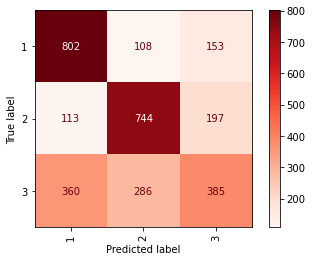

In [35]:
best_knn_model = tuning('knn')

## *Linear Discriminant Analysis (LDA)* <a id = "sec5.4"></a>

Linear Discriminant Ananlysis model (LDA)
Base model accuracy  : 0.670
Classification report : 
              precision    recall  f1-score   support

           1      0.730     0.790     0.759      1063
           2      0.695     0.676     0.685      1054
           3      0.574     0.541     0.557      1031

    accuracy                          0.670      3148
   macro avg      0.666     0.669     0.667      3148
weighted avg      0.667     0.670     0.668      3148

Confusion matrix : 


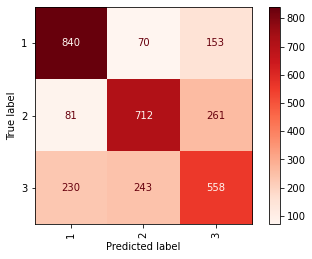

In [36]:
best_lda_model = model_accuracy('lda')

## Conclusion <a id = "sec5.5"></a>

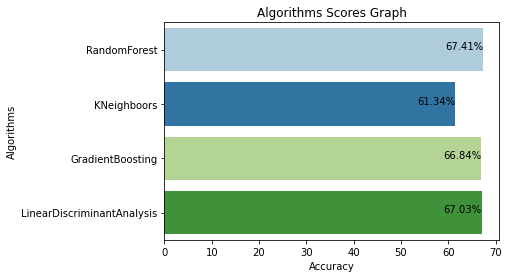

In [37]:
score_summary()

The 3 classes problem is better represented by the `Random Forest model with an accuracy of 67.4%`, `LDA with 67.03%`, `XGB with 66.6%` and `kNN with 61.3%`. Just like the 4 classes problem, the Random Forest model is proven more suitable to predict the target but the same problem persist, the ovefitting of the data to the train set. So in this case again the `XGB` or `LDA` model is more likely to predict on new data with a better accuracy.

# 6. **Formulation 3 (binary problem)** <a id = "sec6"></a>

In [38]:
# Undersampling 
X, y = underSamp(X2, y2)

Original dataset shape :  Counter({1: 129386, 2: 3497})
Resample dataset shape :  Counter({1: 3497, 2: 3497})


In [39]:
# Data separation in train and test sets
X_train, X_test, y_train, y_test = splitting(X, y)

## *Random Forest* <a id = "sec6.1"></a>

Random forest model
Base model accuracy  : 0.790
Classification report : 
              precision    recall  f1-score   support

           1      0.813     0.769     0.790      1078
           2      0.769     0.813     0.790      1021

    accuracy                          0.790      2099
   macro avg      0.791     0.791     0.790      2099
weighted avg      0.792     0.790     0.790      2099

Confusion matrix : 


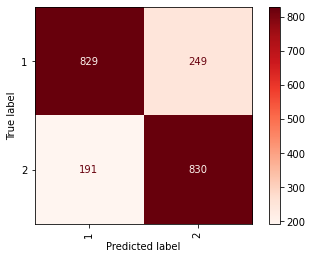

In [40]:
# Performing random forest model
model_rf = model_accuracy('rf')

### Hyperparameters tuning

In [41]:
# Define the grid of parameters
param_grid = {
    'n_estimators': [100, 200,400, 500]
}
# Instantiate the grid search model
grid = GridSearchCV(estimator = model_rf, param_grid = param_grid, cv = 5, n_jobs=-1)
# Fit the grid search to the data
best_rf_grid = grid.fit(X_train, y_train)

Ramdom Forest model best parameters : {'n_estimators': 200}
Random forest final model : RandomForestClassifier(n_estimators=200, random_state=42)
Fitting to the train set : 1.00
Final model Accuracy : 0.790
Base model accuracy : 0.790
Classification report : 
              precision    recall  f1-score   support

           1      0.816     0.764     0.789      1078
           2      0.767     0.818     0.791      1021

    accuracy                          0.790      2099
   macro avg      0.791     0.791     0.790      2099
weighted avg      0.792     0.790     0.790      2099

Confusion matrix : 


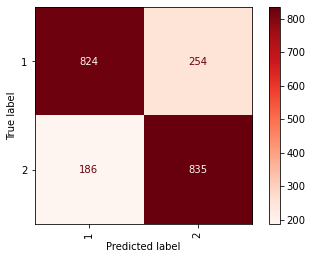

In [42]:
# Perform a tuning of the model specified
best_rf_model = tuning('rf')

## *Extreme Gradient boosting model (XGB)* <a id = "sec6.2"></a>

Extreme gradient boosting model
Fitting to the train set : 0.79
Base model accuracy  : 0.793
Classification report : 
              precision    recall  f1-score   support

           1      0.817     0.770     0.793      1078
           2      0.771     0.818     0.794      1021

    accuracy                          0.793      2099
   macro avg      0.794     0.794     0.793      2099
weighted avg      0.795     0.793     0.793      2099

Confusion matrix : 


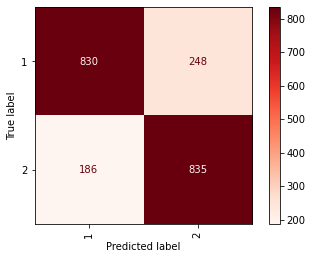

In [43]:
#  Perform XGB model
best_xgb_model = model_accuracy('xgb')

## *k-Nearest Neighbors (kNN)* <a id = "sec6.3"></a>

K-Nearest Neighbors model
Base model accuracy  : 0.762
Classification report : 
              precision    recall  f1-score   support

           1      0.791     0.729     0.759      1078
           2      0.736     0.796     0.765      1021

    accuracy                          0.762      2099
   macro avg      0.763     0.763     0.762      2099
weighted avg      0.764     0.762     0.762      2099

Confusion matrix : 


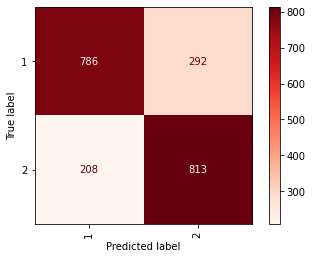

In [44]:
# Perform KNN
model_knn = model_accuracy('knn')

### Hyperparameters tuning for KNN

In [45]:
# Define the grid of parameters
param_grid = {
    'n_neighbors': [5, 7, 10, 15]
}
# Instantiate the grid search model
grid = GridSearchCV(estimator = model_knn, param_grid = param_grid, cv = 5, n_jobs=-1)
# Fit the grid search to the data
best_knn_grid = grid.fit(X_train, y_train)

KNN best parameters : {'n_neighbors': 15}
KNN final model : KNeighborsClassifier(n_neighbors=15)
Fitting to the train set : 0.79
Final model Accuracy : 0.770
Base model accuracy : 0.762
Classification report : 
              precision    recall  f1-score   support

           1      0.810     0.722     0.763      1078
           2      0.736     0.821     0.776      1021

    accuracy                          0.770      2099
   macro avg      0.773     0.771     0.770      2099
weighted avg      0.774     0.770     0.770      2099

Confusion matrix : 


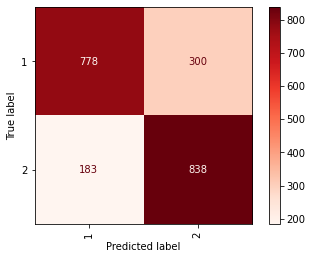

In [46]:
best_knn_model = tuning('knn')

## *Linear Discriminant Analysis (LDA)* <a id = "sec6.4"></a>

Linear Discriminant Ananlysis model (LDA)
Base model accuracy  : 0.786
Classification report : 
              precision    recall  f1-score   support

           1      0.798     0.779     0.789      1078
           2      0.773     0.792     0.782      1021

    accuracy                          0.786      2099
   macro avg      0.786     0.786     0.786      2099
weighted avg      0.786     0.786     0.786      2099

Confusion matrix : 


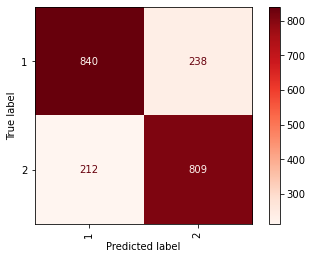

In [47]:
best_lda_model = model_accuracy('lda')

## *Conclusion*<a id = "sec6.5"></a>

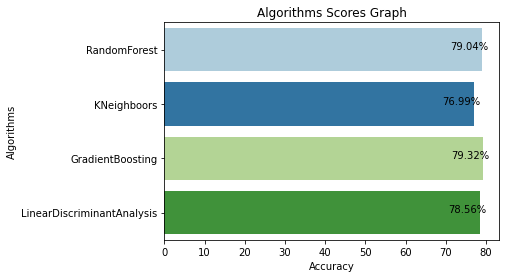

In [48]:
score_summary()

We foud that the binary solution is slightly better modeled by the `XGB with an accuracy of 79,3%`. After that comes the `Random Forest model with 79%` of accuracy, `LDA with 78.5%` and `kNN with 77%`. In this case, there are overfitting with the Random Forest model but we found out that the `XGB` solution perform better.

# 7. **Findings** <a id = "sec7"></a>

After all the solution implemented, we found out that the `Extreme Gradient Boosting` model perform better in all of the formulations. The Random Forest classifier seem at first tried to do a good job but the overfitting problem was undermining the confidence we placed in the predictions. We tried to provide some solutions by using cross validation but it didn't solve the problem.